I use this notebook for any testing and miscellaneous stuff while writing code. \
Of useful stuff this notebook has code for getting differential FIMO hits (ie. peaks where there is a motif hit in one allele and not in other) and for calculating and visualizing confidence weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [4]:
temp = [np.array([0.1,.23]), np.zeros((2,2))]
temp1 = [np.array([0.1,.23]), np.zeros((2,2))]
np.allclose(temp[0],temp1[0])

True

In [43]:
def string_to_char_array(seq):
    """
    Converts an ASCII string to a NumPy array of byte-long ASCII codes.
    e.g. "ACGT" becomes [65, 67, 71, 84].
    """
    return np.frombuffer(bytearray(seq, "utf8"), dtype=np.int8)


def char_array_to_string(arr):
    """
    Converts a NumPy array of byte-long ASCII codes into an ASCII string.
    e.g. [65, 67, 71, 84] becomes "ACGT".
    """
    return arr.tobytes().decode("ascii")


def one_hot_to_tokens(one_hot):
    """
    Converts an L x D one-hot encoding into an L-vector of integers in the range
    [0, D], where the token D is used when the one-hot encoding is all 0. This
    assumes that the one-hot encoding is well-formed, with at most one 1 in each
    column (and 0s elsewhere).
    """
    tokens = np.tile(one_hot.shape[1], one_hot.shape[0])  # Vector of all D
    seq_inds, dim_inds = np.where(one_hot)
    tokens[seq_inds] = dim_inds
    return tokens


def tokens_to_one_hot(tokens, one_hot_dim):
    """
    Converts an L-vector of integers in the range [0, D] to an L x D one-hot
    encoding. The value `D` must be provided as `one_hot_dim`. A token of D
    means the one-hot encoding is all 0s.
    """
    identity = np.identity(one_hot_dim + 1)[:, :-1]  # Last row is all 0s
    return identity[tokens]


def dinuc_shuffle(seq, num_shufs=None, rng=None):
    """
    Creates shuffles of the given sequence, in which dinucleotide frequencies
    are preserved.
    Arguments:
        `seq`: either a string of length L, or an L x D NumPy array of one-hot
            encodings
        `num_shufs`: the number of shuffles to create, N; if unspecified, only
            one shuffle will be created
        `rng`: a NumPy RandomState object, to use for performing shuffles
    If `seq` is a string, returns a list of N strings of length L, each one
    being a shuffled version of `seq`. If `seq` is a 2D NumPy array, then the
    result is an N x L x D NumPy array of shuffled versions of `seq`, also
    one-hot encoded. If `num_shufs` is not specified, then the first dimension
    of N will not be present (i.e. a single string will be returned, or an L x D
    array).
    """
    if type(seq) is str:
        arr = string_to_char_array(seq)
    elif type(seq) is np.ndarray and len(seq.shape) == 2:
        seq_len, one_hot_dim = seq.shape
        arr = one_hot_to_tokens(seq)
    else:
        raise ValueError("Expected string or one-hot encoded array")

    if not rng:
        rng = np.random.RandomState()
   
    # Get the set of all characters, and a mapping of which positions have which
    # characters; use `tokens`, which are integer representations of the
    # original characters
    chars, tokens = np.unique(arr, return_inverse=True)

    # For each token, get a list of indices of all the tokens that come after it
    shuf_next_inds = []
    for t in range(len(chars)):
        mask = tokens[:-1] == t  # Excluding last char
        inds = np.where(mask)[0]
        shuf_next_inds.append(inds + 1)  # Add 1 for next token
 
    if type(seq) is str:
        all_results = []
    else:
        all_results = np.empty(
            (num_shufs if num_shufs else 1, seq_len, one_hot_dim),
            dtype=seq.dtype
        )

    for i in range(num_shufs if num_shufs else 1):
        # Shuffle the next indices
        for t in range(len(chars)):
            inds = np.arange(len(shuf_next_inds[t]))
            inds[:-1] = rng.permutation(len(inds) - 1)  # Keep last index same
            shuf_next_inds[t] = shuf_next_inds[t][inds]

        counters = [0] * len(chars)
       
        # Build the resulting array
        ind = 0
        result = np.empty_like(tokens)
        result[0] = tokens[ind]
        for j in range(1, len(tokens)):
            t = tokens[ind]
            ind = shuf_next_inds[t][counters[t]]
            counters[t] += 1
            result[j] = tokens[ind]

        if type(seq) is str:
            all_results.append(char_array_to_string(chars[result]))
        else:
            all_results[i] = tokens_to_one_hot(chars[result], one_hot_dim)
    return all_results if num_shufs else all_results[0]


In [44]:
from utils import one_hot, unhot
seq = 'ACTGGCTCTCAACAG'
temp = one_hot([seq])[0]


In [45]:
dinuc_shuffle(seq, num_shufs=3)

['ACAACTGGCTCTCAG', 'AACTGGCACTCTCAG', 'ACTCAACTGGCTCAG']

In [47]:
unhot(dinuc_shuffle([temp,temp], num_shufs=3))

ValueError: Expected string or one-hot encoded array

In [9]:
from chrombpnet.loaders import load_data_chrombpnet

_,_,_,y,_,_,p,_,_ = load_data_chrombpnet('cd8','both','_vi_chrom_aug', 'bias')
_,_,_,y1,_,_,p1,_,_ = load_data_chrombpnet('cd8','both','_vi_chrom_aug', 'full')

In [20]:
np.max(np.sum(p1, axis=1))

100789.0

In [53]:
from chrombpnet.model import ChromBPNet
import torch
x = torch.zeros((2,4,2114), dtype=torch.float32)
model = ChromBPNet(num_layers=9)
out = model(x)
print(out[0].shape)
print(out[1].shape)

torch.Size([2, 1000])
torch.Size([2])


In [11]:
import pandas as pd
df = pd.read_csv('betabin/forBetaBinom_b6_only_noGC_noMerge_vi_raw_150bp.csv', index_col=0)
df

,0,1,2,3,4,5,6,7,8,9,...,33133,33134,33135,33136,33137,33138,33139,33140,33141,33142
0,140.0,164.5,6.0,27.0,33.0,39.0,176.0,42.0,41.0,2.0,...,47.5,42.0,136.0,27.0,242.5,539.5,146.0,73.0,36.5,156.0
1,112.5,148.0,2.0,12.0,16.5,19.5,149.5,32.0,20.0,2.5,...,44.5,23.5,98.0,24.0,191.5,335.0,132.0,44.0,29.0,147.5
2,161.0,146.5,2.0,20.0,17.0,28.5,178.0,31.0,39.0,4.0,...,60.5,24.0,141.0,27.0,301.0,521.5,189.5,55.0,39.0,196.5
3,138.5,171.5,1.0,19.0,29.0,21.0,184.5,25.5,40.0,2.0,...,49.0,31.5,112.5,26.0,252.5,464.0,193.0,62.0,49.0,202.0
4,131.0,175.0,2.0,34.0,24.0,18.0,184.0,52.5,43.0,4.5,...,82.0,33.0,126.0,23.0,272.5,473.0,177.0,70.0,40.5,183.0


In [12]:
df = pd.read_csv('betabin/forBetaBinom_ca_only_noGC_noMerge_vi_raw_150bp.csv', index_col=0)
df

,0,1,2,3,4,5,6,7,8,9,...,33133,33134,33135,33136,33137,33138,33139,33140,33141,33142
0,139.0,159.5,45.0,24.0,63.0,36.0,214.0,79.0,1.0,3.0,...,47.5,36.0,139.0,35.0,268.5,542.5,140.0,28.0,26.5,202.0
1,110.5,129.0,44.0,19.0,36.5,19.5,174.5,49.0,0.0,2.5,...,41.5,23.5,81.0,32.0,173.5,333.0,131.0,21.0,25.0,164.5
2,137.0,154.5,47.0,23.0,46.0,31.5,205.0,72.0,1.0,6.0,...,59.5,43.0,105.0,57.0,277.0,518.5,188.5,32.0,39.0,208.5
3,114.5,151.5,41.0,20.0,53.0,22.0,222.5,57.5,1.0,1.0,...,44.0,30.5,117.5,45.0,227.5,464.0,197.0,35.0,44.0,224.0
4,133.0,154.0,44.0,21.0,52.0,19.0,187.0,63.5,1.0,6.5,...,90.0,37.0,124.0,30.0,275.5,471.0,179.0,52.0,47.5,180.0


In [13]:
df = pd.read_csv('betabin/forBetaBinom_peakID_only_noGC_noMerge_vi_raw_150bp.csv', index_col=0)
df

,0
0,1:10038066
1,1:10039792
2,1:100738920
3,1:10089714
4,1:101902423
...,...
33138,15:99735850
33139,15:99772515
33140,15:99803267
33141,15:99875515


# Random testing

In [15]:
import torch
from model import pairScan
model = pairScan(2,0.2)
# x = torch.zeros((2,2,4,300))
# _ = model(x)
# print(sum([p.numel() for p in model.parameters()]))


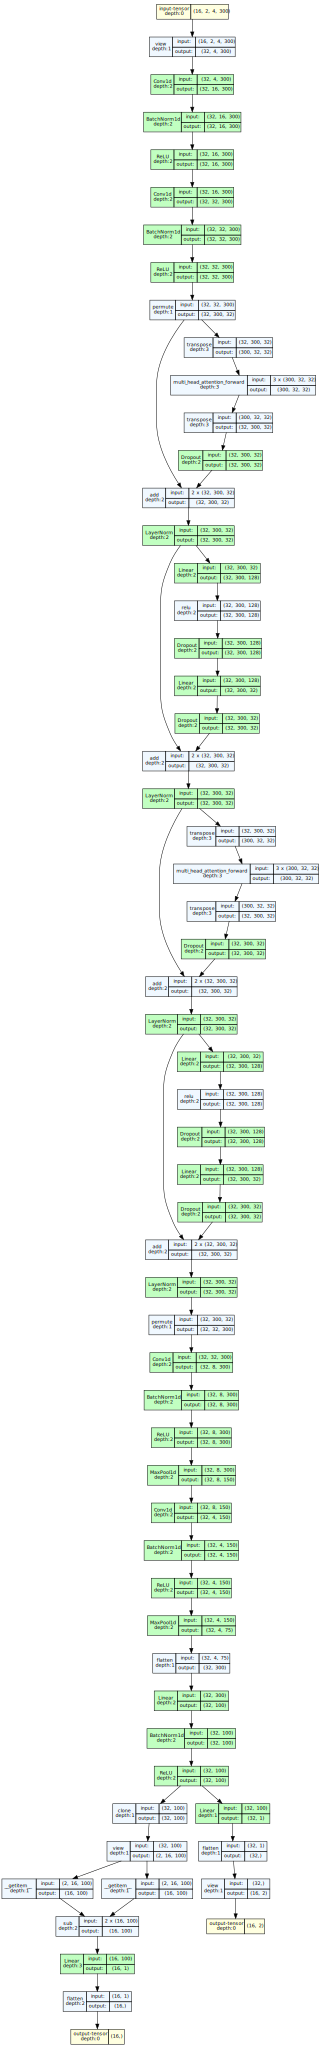

In [19]:
import graphviz
from torchview import draw_graph
draw_graph(model, input_size=(16,2,4,300), hide_inner_tensors=True, hide_module_functions=True).visual_graph

# ISM testing

In [2]:
import numpy as np
import pysam
from tqdm.notebook import tqdm
import pandas as pd
import os
import datetime
import h5py

basedir = '/data/leslie/shared/ASA/'
aligndir = f'{basedir}pseudodiploid/atac/'
ctype = 'cd8'

datadir = f'{basedir}mouseASA/{ctype}/cast/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']
seqlen = 300

In [8]:
from run import load_data
modelname = 'ad'
dataset = 'both'
use_prior = '1'
batchsize = '16'
gc = ''
ident = '_vi_150bp'

predspath = f'{basedir}mouseASA/{ctype}/cast/preds/test_both_7.npy'

print(predspath)
print(datetime.datetime.fromtimestamp(os.path.getmtime(predspath)))
y_pred = np.load(predspath)  # (7274,)
_,_,_,_,_,y_test = load_data(ctype,dataset,gc+ident,get_rc=False,frac=0.)

y_test = y_test.T.reshape(-1)   # (7274,)

true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]   # (3637,)
pred_fc = y_pred[len(y_pred)//2:] - y_pred[:len(y_pred)//2]

print(np.max(np.abs(true_fc)))
print(np.max(np.abs(pred_fc)))

/data/leslie/shared/ASA/mouseASA/cd8/cast/preds/test_both_7.npy
2023-07-27 05:14:36.334509
4.279732252295876
4.1918697


In [9]:
# load the positive summits
from utils import unhot
flag = True    # True for specific peak, False for entire test set

if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{datadir}/summits{ident}.csv', header=None)
print(len(summits))

33143


In [10]:
# FA code, just plug in the value of the summit in seq_name along with your trained model checkpoint
import torch
from run import load_data
from model import pairScan, pairScanWrapper
from utils import trim_weights_dict
from captum.attr import IntegratedGradients
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
method = 'ISM'

dataset = 'both'
use_prior = '1'
SAVEPATH = f'{basedir}mouseASA/{ctype}/cast/ckpt_models/test_both_7.hdf5'
print(SAVEPATH)
model = pairScan(2, 0.2)
model.load_state_dict(torch.load(SAVEPATH), strict=False)
model.to(DEVICE)
model.eval()

if flag:
    # code in case the locus is out of test set
    # finding a particular summit eg. 12:4065711
    seq_name = '12:4065711'.split(':')
    c = int(seq_name[0])
    lims = [int(k) for k in seq_name[1].split('-')]
    print(c, lims)
    if len(lims)>1: # left and right limits given
        temp = summits.iloc[np.where(summits[0]==c)[0],:]
        temp = temp.iloc[list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) )[0], 1]
    else:           # summit location given
        temp = lims[0]
    # find dataset with chromosome c
    i = [i for i in range(len(chroms)) if c in chroms[i]][0]
    print(f'found in {name[i]}..')
    x,y = [item for j,item in enumerate(load_data(ctype,'both',gc+ident,get_rc=False,frac=0.)) if (j==i or j==i+3)]
    x = x.reshape(-1, x.shape[-2], x.shape[-1])
    y = y.reshape(-1)
    
    # accumulate peak numbers in order to get index in x of particular summit
    idx = 0
    for chrom in chroms[i]:
        if chrom != c:
            idx += len(np.where(summits[0]==chrom)[0])
        else:
            chromsummits = summits.iloc[np.where(summits[0]==chrom)[0],:]
            idx += np.where(chromsummits[1]==temp)[0][0]
            break
    
    x = x[[idx*2,idx*2+1]]    # (2,300,4)
    y = y[[idx*2,idx*2+1]]    # (2,)
    print(y[1]-y[0])
    x_dna = unhot(x)

else:  # for test set
    _,_,x,_,_,y = load_data(ctype, 'both', gc+ident, get_rc=False, frac=0.)
    y = y.reshape(-1)
    x_dna = unhot(x.reshape(-1, x.shape[-2], x.shape[-1]))

    chromsummits = []
    for i in chrom_test:
        chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
    chromsummits = np.concatenate(chromsummits)

/data/leslie/shared/ASA/mouseASA/cd8/cast/ckpt_models/test_both_7.hdf5
12 [4065711]
found in train..
-4.005664461672344


In [11]:
from utils import ISM
baseline = torch.from_numpy(x.transpose(0,2,1).astype(np.float32))
ism_scores = ISM(baseline, model)

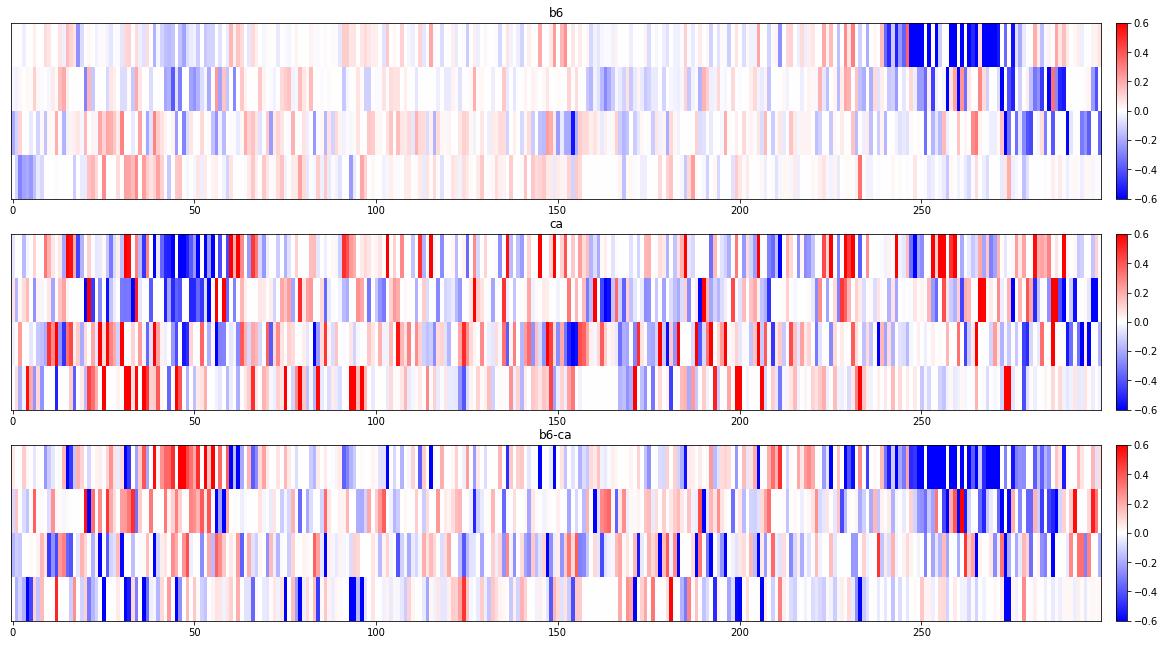

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(3,1, figsize=(20,11))
allele = ['b6','ca','b6-ca']
for i in range(3):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size="1%", pad=0.2,)
    if i<2:
        a = ax[i].imshow(ism_scores[i], cmap='bwr', vmax=0.6, vmin=-0.6, aspect='auto')
    else:
        a = ax[i].imshow(ism_scores[0]-ism_scores[1], cmap='bwr', vmax=0.6, vmin=-0.6, aspect='auto')
    cbar = plt.colorbar(a, cax=cax)
    ax[i].set_yticks([])
    ax[i].set_title(allele[i])
plt.show()

chr12: 4065561-4065861
True Log2fc (cast/b6): -4.005664461672344
b6       ISM


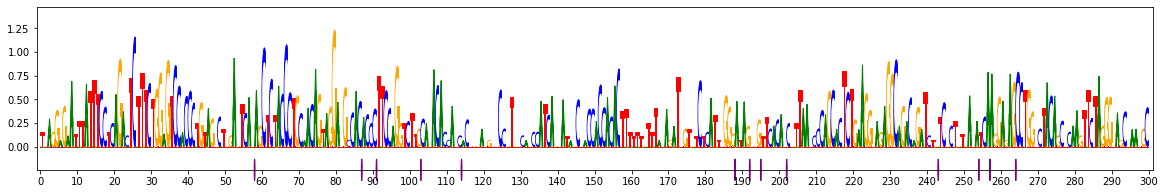

cast     ISM


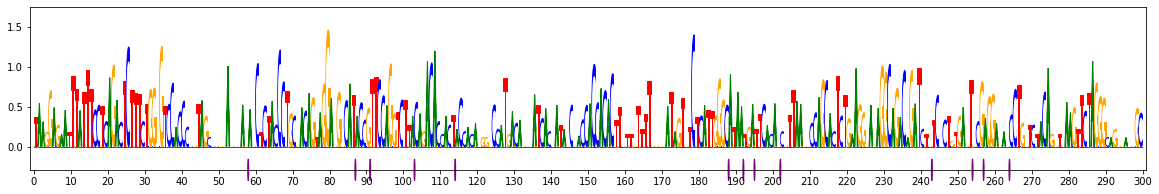

In [73]:
import deeplift
from deeplift.visualization import viz_sequence
import matplotlib.patches

if flag:
    i=0
    print(f'chr{c}: {temp-seqlen//2}-{temp+seqlen//2}')
    print('True Log2fc (cast/b6):', y[1]-y[0])
    # snp_idx, to be replaced with code to find SNP locations
    idx = [58, 87, 91, 103, 114, 188, 192, 195, 202, 243, 254, 257, 264] #12:4065711
#     idx = [2,3,19,106,142,233] #17:27375655
#     idx=[24, 39, 49, 73, 156, 199] #19:53699992
else:
    rank = 20       # fold change rank of true accessibility change
    i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
    if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
        c = chrom_test[1]
    else:
        c = chrom_test[0]
    
    # get locations of SNPs and indels
    idx = get_loci(mods, c, chromsummits[i])

    print(f'chr{c}: {chromsummits[i]-seqlen//2}-{chromsummits[i]+seqlen//2}')
    print('SNP/Indel location:', idx)
    print('True Log2fc (cast/b6):', true_fc[i])

seq_b6 = x_dna[i]
seq_ca = x_dna[len(x_dna)//2+i]

ylims = []
scores = x*attr.transpose((0,2,1))   # (2,300,4) scores for b6,ca
print('b6      ', method)
viz_sequence.plot_weights(scores[0], subticks_frequency=10, figsize = (20,3), snp_list=idx, ylims=ylims)
print('cast    ', method)
viz_sequence.plot_weights(scores[1], subticks_frequency=10, figsize = (20,3), snp_list=idx, ylims=ylims)

## Differential FIMO hit loci

In [2]:
import pandas as pd
import numpy as np
path = '/data/leslie/shared/ASA/mouseASA/cd8/cast/data/fimo/'
df_b6 = pd.read_csv(path+'fimo_b6_train.tsv', sep='\t').iloc[:-3,:]
df_ca = pd.read_csv(path+'fimo_ca_train.tsv', sep='\t').iloc[:-3,:]
# get unique entries (exclusive-or) in both dataframes
temp1 = set(df_b6['sequence_name'])
temp2 = set(df_ca['sequence_name'])
temp = list(temp1.union(temp2) - temp1.intersection(temp2))
# get allele-specific motif hits
df_b6 = df_b6[df_b6['sequence_name'].isin(temp)].reset_index(drop=True)
df_ca = df_ca[df_ca['sequence_name'].isin(temp)].reset_index(drop=True)

In [10]:
datadir='/data/leslie/shared/ASA/mouseASA/cd8/cast/data/'
summits = pd.read_csv(datadir+'cutrun/tbet/summits_tbetfiltered.csv')
summits.head(20)

,chr,summit,diff,b6,ca
0,17,70963761,225,25,250
1,2,5379287,190,6,196
2,7,130834538,150,5,155
3,9,110281308,110,4,114
4,2,69380492,108,110,2
5,18,85698032,108,6,114
6,8,3754448,96,8,104
7,9,108144752,75,7,82
8,5,137857059,73,76,3
9,15,86195220,71,3,74


In [25]:
i=0
hits_b6 = []
hits_ca = []
for i in range(len(summits)):
    chrom, pos = summits.iloc[i,:2]
    hits_b6.append(np.where(df_b6['sequence_name']==f'{chrom}:{pos}')[0])
    hits_ca.append(np.where(df_ca['sequence_name']==f'{chrom}:{pos}')[0])
#     print(np.where(df_b6['sequence_name']==f'{chrom}:{pos}')[0])
#     print(np.where(df_ca['sequence_name']==f'{chrom}:{pos}')[0])

In [44]:
np.where(df_b6['sequence_name']=='8:86838925')[0]

array([36])

In [30]:
hits_b6[:50]

[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([36]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([106]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([117]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array

In [31]:
hits_ca[:50]

[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([28]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)

In [45]:
df_ca.iloc[0]

motif_id                      1
motif_alt_id         ADGTGWSAHN
sequence_name       19:53699992
start                     193.0
stop                      202.0
strand                        -
score                   13.4364
p-value                0.000001
q-value                   0.298
matched_sequence     AGGTGTGAAA
Name: 0, dtype: object

In [3]:
df_b6

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,1,ADGTGWSAHN,16:96907974,200.0,209.0,+,13.4364,0.000001,0.310,AGGTGTGAAA
1,1,ADGTGWSAHN,12:4065711,195.0,204.0,-,13.1273,0.000002,0.310,AGGTGTGAAC
2,1,ADGTGWSAHN,6:50525776,21.0,30.0,+,12.7394,0.000005,0.339,AGGTGTCAAA
3,1,ADGTGWSAHN,8:116636144,242.0,251.0,+,12.7394,0.000005,0.339,AGGTGTCAAA
4,1,ADGTGWSAHN,1:138290204,54.0,63.0,-,12.7212,0.000006,0.339,AGGTGTGAAG
...,...,...,...,...,...,...,...,...,...,...
123,1,ADGTGWSAHN,1:165775783,280.0,289.0,-,10.4121,0.000094,0.574,ATGTGAGAAA
124,1,ADGTGWSAHN,6:30357936,4.0,13.0,+,10.4000,0.000096,0.581,AAGTGAGACA
125,1,ADGTGWSAHN,7:125635632,25.0,34.0,+,10.4000,0.000096,0.581,AAGTGAGACA
126,1,ADGTGWSAHN,2:77946312,122.0,131.0,-,10.3515,0.000099,0.590,AGGTGTTACT


In [4]:
df_ca

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,1,ADGTGWSAHN,19:53699992,193.0,202.0,-,13.4364,0.000001,0.298,AGGTGTGAAA
1,1,ADGTGWSAHN,8:34615181,262.0,271.0,-,13.4364,0.000001,0.298,AGGTGTGAAA
2,1,ADGTGWSAHN,11:70988318,135.0,144.0,+,13.1273,0.000002,0.298,AGGTGTGAAC
3,1,ADGTGWSAHN,4:48034522,151.0,160.0,+,13.1273,0.000002,0.298,AGGTGTGAAC
4,1,ADGTGWSAHN,9:78010942,63.0,72.0,+,13.0788,0.000003,0.309,AGGTGTGACA
...,...,...,...,...,...,...,...,...,...,...
114,1,ADGTGWSAHN,9:108284570,160.0,169.0,-,10.4061,0.000095,0.582,AGGTGTTATA
115,1,ADGTGWSAHN,1:128675812,27.0,36.0,-,10.3879,0.000097,0.586,ATGTGTCAAG
116,1,ADGTGWSAHN,14:47358096,86.0,95.0,-,10.3879,0.000097,0.586,ATGTGTCAAG
117,1,ADGTGWSAHN,1:153709608,158.0,167.0,+,10.3758,0.000098,0.589,AAGTGTCACG


## Confidence Weights

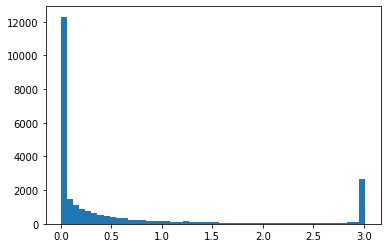

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

def get_confweights():
    train_sig_path = '/data/leslie/shared/ASA/mouseASA/cd8/data/significance/betabinom_result_combCounts_150bp_trainOnly.csv'
    pvals = pd.read_csv(train_sig_path)['p.adj']
    zscores = zscore(-np.log10(pvals+1e-5))
    zscores += abs(min(zscores))
    return zscores

plt.hist(get_confweights(), bins=50)
plt.show()

In [184]:
temp = get_confweights()
len(temp[temp>0.5])

7366

In [178]:
np.unique(np.sort(temp))

array([0.00000000e+000, 6.65177193e-305, 6.52593435e-275, ...,
       9.99914748e-001, 9.99958408e-001, 1.00000000e+000])

In [154]:
train_sig_path = '/data/leslie/shared/ASA/mouseASA/cd8/data/significance/betabinom_result_combCounts_150bp_trainOnly.csv'
pvals = pd.read_csv(train_sig_path)['p.adj']

In [157]:
len(pvals[pvals<0.05])

5951

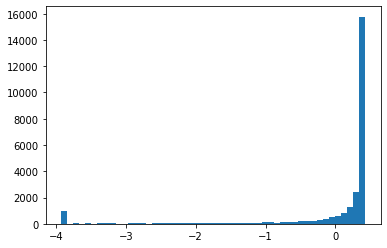

In [152]:
plt.hist(get_betabin_zscores(), bins=50)
plt.show()